In [144]:
import random
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error

In [57]:
dataset = pd.read_csv('/home/anna/Desktop/ML Optimization/CovariateStableReg/abalone_original.csv')

In [58]:
dataset

,sex,length,diameter,height,whole-weight,shucked-weight,viscera-weight,shell-weight,rings
0,M,91,73,19,102.8,44.9,20.2,30.0,15
1,M,70,53,18,45.1,19.9,9.7,14.0,7
2,F,106,84,27,135.4,51.3,28.3,42.0,9
3,M,88,73,25,103.2,43.1,22.8,31.0,10
4,I,66,51,16,41.0,17.9,7.9,11.0,7
...,...,...,...,...,...,...,...,...,...
4172,F,113,90,33,177.4,74.0,47.8,49.8,11
4173,M,118,88,27,193.2,87.8,42.9,52.1,10
4174,M,120,95,41,235.2,105.1,57.5,61.6,9
4175,F,125,97,30,218.9,106.2,52.2,59.2,10


In [66]:
def plot_data(X, X_shift):
    sns.set(style="whitegrid")
    num_covariates = X.shape[1]

    # Create a grid of subplots
    fig, axes = plt.subplots(1, num_covariates, figsize=(25, 5))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        # Plot for Covariate i in both datasets
        sns.histplot(X[:, i], kde=True, color='blue', label='Original', alpha=0.7, ax=ax)
        sns.histplot(X_shift[:, i], kde=True, color='orange', label='Shifted', alpha=0.7, ax=ax)
        
        ax.set_title(f'Distribution of Covariate {i}')
        ax.legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [67]:
X = dataset.drop(['sex', 'rings'], axis=1)
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

In [91]:
features_to_shift = ['length', 'diameter', 'height', 'whole-weight', 'shucked-weight', 'viscera-weight', 'shell-weight']
column_indices = [X.columns.get_loc(col) for col in features_to_shift]
X_shifted = X_normalized.copy()
shift_values = np.random.uniform(low=0, high=2, size=(X.shape[0], len(features_to_shift)))
X_shifted[:, column_indices] = X_shifted[:, column_indices] + shift_values

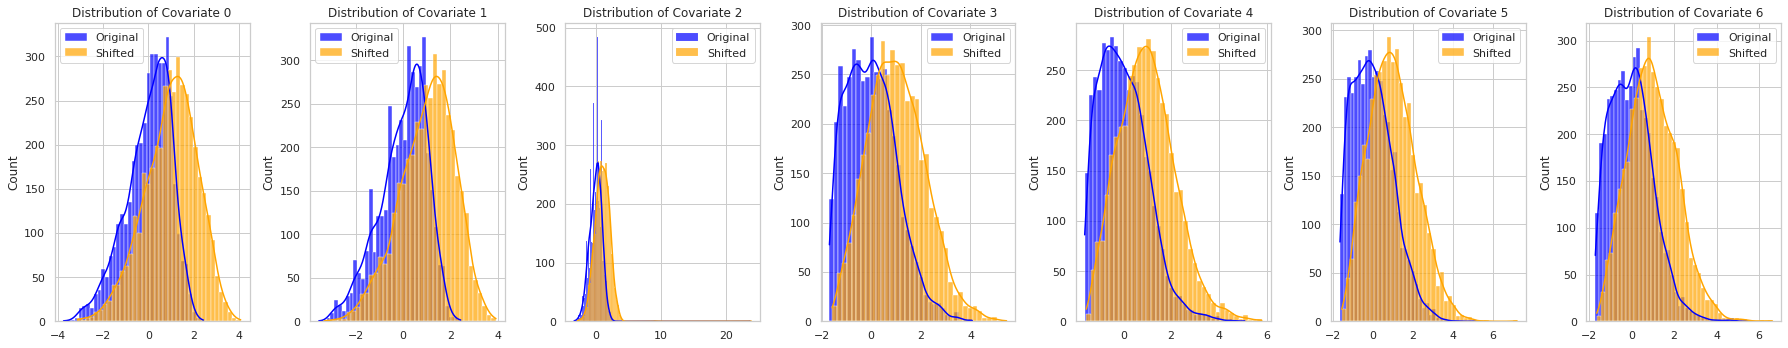

In [92]:
plot_data(X_normalized, X_shifted)

In [93]:
# save dataframe
shifted_dataset = dataset.copy()
shifted_dataset[features_to_shift] = X_shifted
shifted_dataset.to_csv("shifted_normalized_abalone.csv")

In [75]:
normalized_dataset = dataset.copy()
normalized_dataset[features_to_shift] = X_normalized
normalized_dataset.to_csv("normalized_abalone.csv")

### get weights
- train model
- save weights, save indices of splits 

In [129]:
y = dataset["rings"]
num_indices = int(round(0.9*len(y)))
train_indices = random.sample(range(len(y)), num_indices)
test_indices = list(set(range(len(y))) - set(train_indices))

In [135]:
def split_dataset(X, y, X_shifted, train_prop=0.9):
    num_indices = int(round(0.9*len(y)))
    train_indices = random.sample(range(len(y)), num_indices)
    test_indices = list(set(range(len(y))) - set(train_indices))
    
    train_X, train_y = X[train_indices, :], y[train_indices]
    test_X, test_y = X_shifted[test_indices, :], y[test_indices]
    
    save_as_csv("abalone/train_X.csv", train_X)
    save_as_csv("abalone/test_X.csv", test_X)
    train_y.to_csv("abalone/train_y.csv")
    test_y.to_csv("abalone/test_y.csv")
    return train_X, train_y, test_X, test_y

In [136]:
def check_accuracy(y_pred, y_true):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    print(
        f"""
            accuracy: {round(accuracy, 3)}
            precision: {round(precision, 3)}
            recall: {round(recall, 3)}
    """
    )
    return None

In [137]:
def save_as_csv(file_name, data):
    if isinstance(data, np.ndarray):
        data = data.tolist()

    # Now data is either a regular Python list or some other iterable
    with open(file_name, 'w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerows(data)

    print(f'The array has been saved to {file_name}')
    return None

In [147]:
def covariate_weights(X1, X2):
    X_combined = np.vstack((X1, X2))
    y_combined = np.hstack((np.zeros(X1.shape[0]), np.ones(X2.shape[0])))
    
    lr = LogisticRegression().fit(X_combined, y_combined)
    y_pred_combined = lr.predict(X_combined)
    check_accuracy(y_pred_combined, y_combined)
    
    y_pred_combined_prob = lr.predict_proba(X1)
    weights = y_pred_combined_prob[:,1] / y_pred_combined_prob[:,0]
    save_as_csv("weights", [weights])
    
    return weights

In [148]:
y = dataset["rings"]
train_X, train_y, test_X, test_y = split_dataset(X_normalized, y, X_shifted)
weights = covariate_weights(train_X, test_X)

The array has been saved to abalone/train_X.csv
The array has been saved to abalone/test_X.csv

            accuracy: 0.91
            precision: 0.918
            recall: 0.108
    
The array has been saved to weights


In [150]:
def compute_rmse(X_train,y_train, X_test, y_test, weight=None):
    if weight is not None:
        # train a weighted model
        lr = LinearRegression().fit(X_train, y_train, weight)
        y_hat_train_weight = lr.predict(X_train)
        y_hat_test_weight = lr.predict(X_test)
        print("Scores with weights for train set:")
        print(mean_squared_error(y_train,y_hat_train_weight))
        print("")
        print("RMSE with weights for test set:")
        print(mean_squared_error(y_test, y_hat_test_weight))

    else:
        # train simple linear regression
        lr = LinearRegression().fit(X_train, y_train)
        y_hat_train = lr.predict(X_train)
        y_hat_test = lr.predict(X_test)
        print("Scores for train set:")
        print(mean_squared_error(y_train, y_hat_train))
        print("")
        print("RMSE for test set:")
        print(mean_squared_error(y_test, y_hat_test))

    return lr

In [151]:
compute_rmse(train_X, train_y, test_X, test_y, weight=weights)

Scores with weights for train set:
5.522302237704521

RMSE with weights for test set:
17.898888410134358


LinearRegression()

In [152]:
compute_rmse(train_X, train_y, test_X, test_y)

Scores for train set:
4.785410321118414

RMSE for test set:
24.88218160212668


LinearRegression()